In [1]:
import os
import pandas as pd
from anndata import read_h5ad
import scanpy as sc
import scregseg
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Scregseg for feature identification

This tutorial shows how to run Scregseg on single-cell ATAC-seq data.

Scregseg implements an HMM-based segmentation model based on Dirichlet-Multinomial emission probabilities
which allows to classify the genome in states with distinct cross-cell accessibility profiles. Distinct states may
then represent regions that are specifically accessible in subpopulations of cells, across all cells or merely reflect
genomic background signal.

One way to make use of Scregseg is by running it on genome-wide single-cell ATAC-seq data. Subsequently,
one could extract putative informative states and compile a set of informative regions based off of the selected
foreground states. These regions will then be used for the downstream processing, including for 
dimensionality reduction.

We will first start by downloading the tutorial dataset which we obtain from 10x Genomics.

### Obtaining the dataset

In [2]:
# first we download example scATAC-seq data
#!wget -O atac_v1_pbmc_5k_fragments.tsv.gz https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz

# sometimes bedtools fails when processing the original *.tsv.gz files, but unpacking and packing seems to help
#!gunzip atac_v1_pbmc_5k_fragments.tsv.gz
#!gzip atac_v1_pbmc_5k_fragments.tsv

#!wget -O atac_v1_pbmc_5k_singlecell.csv https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_singlecell.csv

--2021-02-11 21:05:59--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 976353254 (931M) [text/tab-separated-values]
Saving to: ‘atac_v1_pbmc_5k_fragments.tsv.gz’

100%[======================================>] 976.353.254 1,69MB/s   in 17m 21s

2021-02-11 21:23:21 (916 KB/s) - ‘atac_v1_pbmc_5k_fragments.tsv.gz’ saved [976353254/976353254]

gzip: atac_v1_pbmc_5k_fragments.tsv already exists; do you wish to overwrite (y or n)? ^C
gzip: atac_v1_pbmc_5k_fragments.tsv.gz already exists; do you wish to overwrite (y or n)? ^C
--2021-02-11 21:27:06--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_singlecell.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)...

In order to obtain informative features, we will need to perform several steps:

    1. make genome-wide tiling windows
    2. make a countmatrix using the genome-wide bins
    3. filter the raw countmatrix
    4. fit the Scregseg model
    5. inspect the results
    6. export the informative regions along with the countmatrix

### Data preparation

First, be build genome-wide tiling windows

In [2]:
!scregseg make_tile \
          --regions tile1kb.bed \
          --binsize 1000 \
          --fragmentfile atac_v1_pbmc_5k_fragments.tsv.gz

Using TensorFlow backend.


Next, we make a countmatrix.
Since, we already have the fragment files, we can go ahead with them.
Alternatively, it is possible to create a countmatrix from a bam file as well
using the `scregseg bam_to_counts` command.

In [11]:
!scregseg fragments_to_counts \
          --fragmentfile atac_v1_pbmc_5k_fragments.tsv.gz \
          --regions tile1kb.bed \
          --with-fraglen \
          --counts countmatrix.h5ad

Using TensorFlow backend.
... storing 'chrom' as categorical


In the example, we'll save the countmatrix as AnnData dataset, which facilitates easy interoperability with scanpy.
Alternatively, one could save the countmatrix also as `countmatrix.mtx` to save the data in matrix market format.
The latter option makes it easier to continue with the dataset in R.

Next, we subset/filter the raw countmatrix to remove poor quality barcodes.
The 10x Genomics data already contains information from the CellRanger pipeline about the cell quality.
So we first use the determined high-quality cells from there.

To do so, we extract the desired cells from the 10x Genomics metadata:

In [12]:
df = pd.read_csv('atac_v1_pbmc_5k_singlecell.csv')
df = df[df.is__cell_barcode==1]
df[['barcode']].to_csv('qcontrolled_cells.csv', index=False)
print(f'{df.shape[0]} high-quality cells are left for downstream processing')

4654 high-quality cells are left for downstream processing


Then we subset the original countmatrix and regain only the quality controlled cells:

In [14]:
!scregseg subset \
          --incounts countmatrix.h5ad \
          --outcounts filtered_countmatrix.h5ad \
          --subset qcontrolled_cells.csv

Using TensorFlow backend.


Alternatively, it is possible to filter cells and regions using `scregseg filter_counts`

Now, let's check the content of the count matrix

In [15]:
adata = read_h5ad('filtered_countmatrix.h5ad')
adata

AnnData object with n_obs × n_vars = 2880143 × 4654
    obs: 'chrom', 'start', 'end'
    obsm: 'frag_lens'

In [16]:
adata.obs.head()

,chrom,start,end
name,,,
chr1_0_1000,chr1,0,1000
chr1_1000_2000,chr1,1000,2000
chr1_2000_3000,chr1,2000,3000
chr1_3000_4000,chr1,3000,4000
chr1_4000_5000,chr1,4000,5000


In [17]:
adata.var.head()

""
barcode
CTCTCAGTCCGGGCAT-1
CAGGGCTTCTTTCGAT-1
GCCTAGGCAGTGCTCG-1
ACTAACGCAGATGGCA-1
ATTTGTCCAATGCCAT-1


### Model fitting

Now we consume the countmatrix as fit a Scregseg model. For this example,
we shall use a 30 state model and run the model on 30 cores to speedup parameter fitting.

In [1]:
# fit a 40 state model in parallel on 30 cores
!scregseg fit_segment --counts filtered_countmatrix.h5ad \
    --regions tile.bed \
    --labels sample \
    --storage scregseg_fi \
    --randomseed 32 --n_jobs 30 --nstates 30

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
         1  -636550017.7295             +nan
         2  -629475961.5479    +7074056.1816
         3  -626012124.0303    +3463837.5176
         4  -624906670.4807    +1105453.5496
         5  -6

Usually, we find that 30-40 states work well in practice. 
This will result in about 10-20 informative states
leaving the remaining states as background.
We find that increasing the number of states will usually 
result in further splitting up background states. On the other hand,
there the informative foreground states are less frequently further split up,
but remain rather steady across different models.

### Exploring the model results

After having fitted a model and called states, we can explore the
states to get a sense as to which ones might be putative foreground states 
(e.g. cell type specific regions) and which ones might be background states.


Load the Scregseg results:

In [2]:
model = scregseg.Scregseg.load(os.path.join('scregseg_fi', 'dirmulhmm'))

The first indication about the likely functional relevance of a states is given by the state frequency.
That is, how much of the genome is covered by a give state.

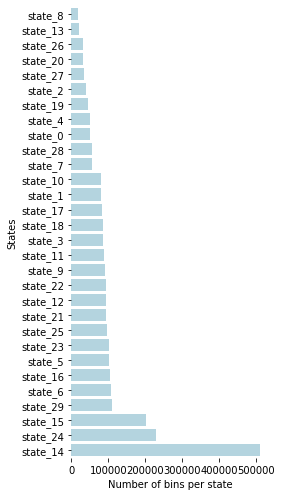

In [3]:
fig, ax =  plt.subplots(figsize=(4,7))
model.plot_state_frequency(ax=ax)
plt.tight_layout()

While some states cover a large fraction of the genome,
others are relatively rare.
In general, rare states are more likely to reflect functional regions, including
cell-type specific regulatory regions, while abundant states are more likely to reflect
genomic background signal.

Different states may be associated with differing read depths.

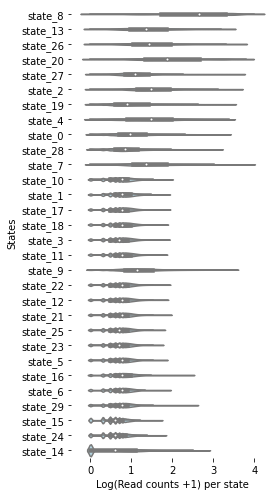

In [4]:
fig, ax =  plt.subplots(figsize=(4,7))
model.plot_readdepth(ax=ax)
plt.tight_layout()

It appears that rare states tend to exhibit higher read counts across cells.

In [5]:
adata = read_h5ad('filtered_countmatrix.h5ad')

Next, we could explore the cell-state relationship. 
To this end, we ask whether a given state is enriched in the 
accessible part of a given cell
relative to the overall state frequencies across the genome.

/home/wkopp/anaconda3/envs/scregseg/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


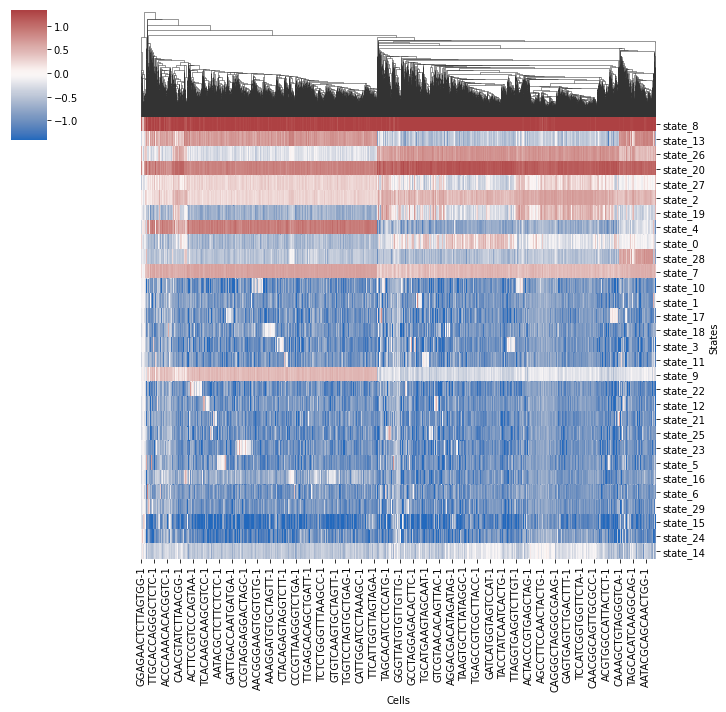

In [6]:
_ = model.plot_cell_state_association(adata)

From this we can make several interesting observations:

1. There are usually one or more states that are overrepresented in all (or most) cells. Such states represent constitutively accessible regions. In the example, states 8 and 20 reflect consitutive accessibility.
These are usually associated with gene promoter regions.
2. Some states are enriched only in a subpopulation of the cells. These reflect cell-type specific accessibility e.g. of regulatory regions. For example, state 13 and 4.
3. Some states don't seem to be specifically enriched in any subpopulation. These states are likely background states. For example, state 14.

Finally, we can explore the state-specific fragment length distribution.

In [16]:
ax

<AxesSubplot:xlabel='Log(Read counts +1) per state', ylabel='States'>

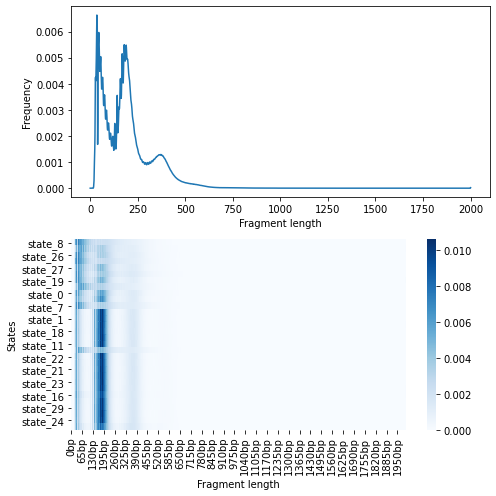

In [9]:
fig, axes=plt.subplots(2, figsize=(7,7))
model.plot_fragmentsize(adata, ax=axes[0], bystate=False)
model.plot_fragmentsize(adata, ax=axes[1], cmap="Blues")
plt.tight_layout()


We observe that putative functional (i.e. rare states) and background states tend to 
show distinct fragment length distribution profiles.
Background states tend to exhibit a depletion of short fragment (<140bp), 
while putative functional regions are usually enriched for short fragment sizes.
Short fragment length are suggestive of nucleosome free regions, which are characteristic
of regulatory regions such as promoters or enhancers.
On the other hand, long fragment lengths (>140bp) reflect nucleosome spanning reads.

Taken together, these observations suggest that likely functional 
states tend to be 1. rare, 2. sometimes exhibit higher read depth, 
3. tend to be enriched in subpopulations of the cells or all cells
and 4. enriched for short fragment lengths that indicate nucleosome free regions.

rare states are likely functional and are informative 
for downstream analysis tasks such as dimensionality reduction or clustering.

Functional (informative) states 
likely functional states occur at a rare frequency, show cell specific enrichment,
and tend to be enriched for short fragment lengths (shorter than one nucleosome).
On the other hand, frequent states are usually less cell specific and are enriched 
for long fragment lengths (nucleosome spanning fragments).

### Export putative informative regions

We can export regions from likely informative states and use them for 
downstream tasks such as dimensionality reduction or clustering.

A simple strategy would be to just extract regions associated with the X rarest states. In this example, we might consider the eleven rarest states.

In [13]:
!scregseg seg_to_bed \
          --storage scregseg_fi \
          --threshold 0.9 \
          --nstates 11 \
          --nregsperstate 5000 \
          --no_bookended_merging \
          --counts filtered_countmatrix.h5ad \
          --output informative_11_rarest_states.bed

Using TensorFlow backend.
/home/wkopp/anaconda3/envs/scregseg/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'chrom' as categorical
... storing 'name' as categorical
... storing 'strand' as categorical
... storing 'itemRbg' as categorical


We recommend to use a posterior probability threshold (using --threshold) such that only confident state calls of at least 0.9 in the example above
are considered.
Additionally, we find that it is usually sufficient to just use a subset 
of the regions for a give state (e.g. 5000 regions as determined by --nregsperstate) due to the inherent redundancy within a state.

Alternatively, it is possible to choose the putative informative states manually. In this example,
we have added state_9, since it also exhibits hallmarks of likely functional regions even though it is not too rare.

In [15]:
!scregseg seg_to_bed \
          --storage scregseg_fi \
          --threshold 0.9 \
          --method manualselect \
          --statenames state_8 state_13 state_26 state_20 state_27 state_2 state_19 state_4 state_0 state_7 state_9 \
          --nregsperstate 5000 \
          --no_bookended_merging \
          --counts filtered_countmatrix.h5ad \
          --output informative_manual_states.bed

Using TensorFlow backend.
/home/wkopp/anaconda3/envs/scregseg/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'chrom' as categorical
... storing 'name' as categorical
... storing 'strand' as categorical
... storing 'itemRbg' as categorical
